In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset from the CSV file
df = pd.read_csv('movie_watch.csv')
print("Initial shape of dataset:", df.shape)
display(df.head())

# Data Cleaning: Drop rows where watch_time_hour is 0
df = df[df['watch_time_hour'] != 0]
print("Shape after dropping rows with watch_time_hour == 0:", df.shape)

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Ensure numeric columns have the proper types
df['watch_time_hour'] = pd.to_numeric(df['watch_time_hour'])
df['avg_rating_given'] = pd.to_numeric(df['avg_rating_given'])

Initial shape of dataset: (100, 3)


,watch_time_hour,genre_preference,avg_rating_given
0,13,action,2.037554
1,4,comedy,1.350365
2,15,thriller,1.359665
3,14,thriller,1.772998
4,14,comedy,1.202237


Shape after dropping rows with watch_time_hour == 0: (98, 3)
Missing values in each column:
watch_time_hour     0
genre_preference    0
avg_rating_given    0
dtype: int64


In [9]:
print(df.head())

   watch_time_hour genre_preference  avg_rating_given watch_segment  \
0               13           action          2.037554        medium   
1                4           comedy          1.350365           low   
2               15         thriller          1.359665          high   
3               14         thriller          1.772998        medium   
4               14           comedy          1.202237        medium   

  rating_category  rating_encoded  
0             Low               1  
1             Low               1  
2             Low               1  
3             Low               1  
4             Low               1  


In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, 0 to 99
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   watch_time_hour   98 non-null     int64   
 1   genre_preference  98 non-null     object  
 2   avg_rating_given  98 non-null     float64 
 3   watch_segment     98 non-null     category
 4   rating_category   98 non-null     category
 5   rating_encoded    98 non-null     int64   
dtypes: category(2), float64(1), int64(2), object(1)
memory usage: 4.3+ KB
None


In [2]:
# Import StandardScaler for normalization later
from sklearn.preprocessing import StandardScaler

# Create a new column for watch time segmentation using quantiles.
# We'll create three segments: low, medium, high.
df['watch_segment'] = pd.qcut(df['watch_time_hour'], q=3, labels=['low', 'medium', 'high'])
print("Watch segmentation counts:")
print(df['watch_segment'].value_counts())

# One-hot encode the categorical 'genre_preference' column
df_encoded = pd.get_dummies(df, columns=['genre_preference'])
print("Data after one-hot encoding genre_preference:")
display(df_encoded.head())

# Normalize the numeric columns 'watch_time_hour' and 'avg_rating_given'
scaler = StandardScaler()
df_encoded[['watch_time_hour_scaled', 'avg_rating_given_scaled']] = scaler.fit_transform(
    df_encoded[['watch_time_hour', 'avg_rating_given']]
)
print("Dataset with normalized numerical features:")
display(df_encoded.head())

Watch segmentation counts:
watch_segment
low       37
high      33
medium    28
Name: count, dtype: int64
Data after one-hot encoding genre_preference:


,watch_time_hour,avg_rating_given,watch_segment,genre_preference_action,genre_preference_comedy,genre_preference_drama,genre_preference_thriller
0,13,2.037554,medium,True,False,False,False
1,4,1.350365,low,False,True,False,False
2,15,1.359665,high,False,False,False,True
3,14,1.772998,medium,False,False,False,True
4,14,1.202237,medium,False,True,False,False


Dataset with normalized numerical features:


,watch_time_hour,avg_rating_given,watch_segment,genre_preference_action,genre_preference_comedy,genre_preference_drama,genre_preference_thriller,watch_time_hour_scaled,avg_rating_given_scaled
0,13,2.037554,medium,True,False,False,False,0.249471,-0.643541
1,4,1.350365,low,False,True,False,False,-1.134387,-1.251421
2,15,1.359665,high,False,False,False,True,0.556995,-1.243194
3,14,1.772998,medium,False,False,False,True,0.403233,-0.877564
4,14,1.202237,medium,False,True,False,False,0.403233,-1.382453


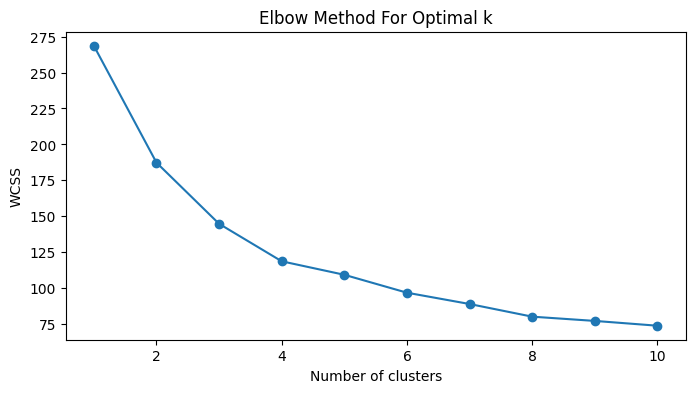

Cluster counts:
cluster
0    36
2    36
1    26
Name: count, dtype: int64


In [3]:
# Import necessary libraries for clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select features for clustering: the scaled numeric features and encoded genre columns.
feature_cols = [
    'watch_time_hour_scaled',
    'avg_rating_given_scaled',
    'genre_preference_action',
    'genre_preference_comedy',
    'genre_preference_drama',
    'genre_preference_thriller'
]
X = df_encoded[feature_cols]

# Use the Elbow method to help determine the optimal number of clusters.
wcss = []  # within-cluster sum-of-squares
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

# For this example, we select k = 3 (adjust if needed based on the Elbow plot)
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df_encoded['cluster'] = kmeans.fit_predict(X)

print("Cluster counts:")
print(df_encoded['cluster'].value_counts())

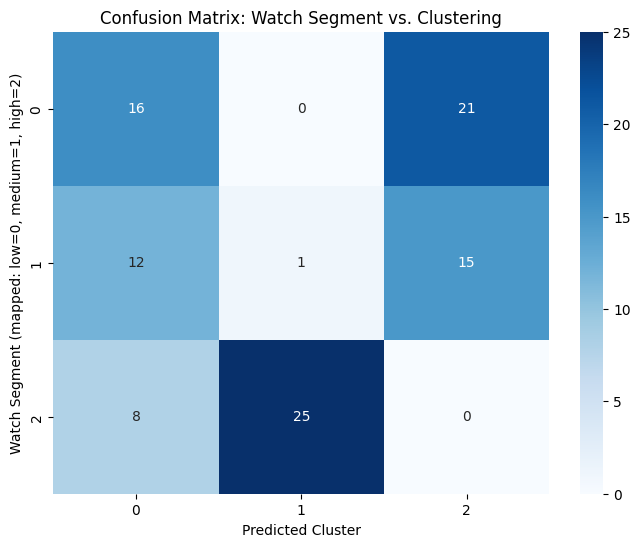

Cross-tabulation between watch_segment and cluster:
cluster         0   1   2
watch_segment            
low            16   0  21
medium         12   1  15
high            8  25   0


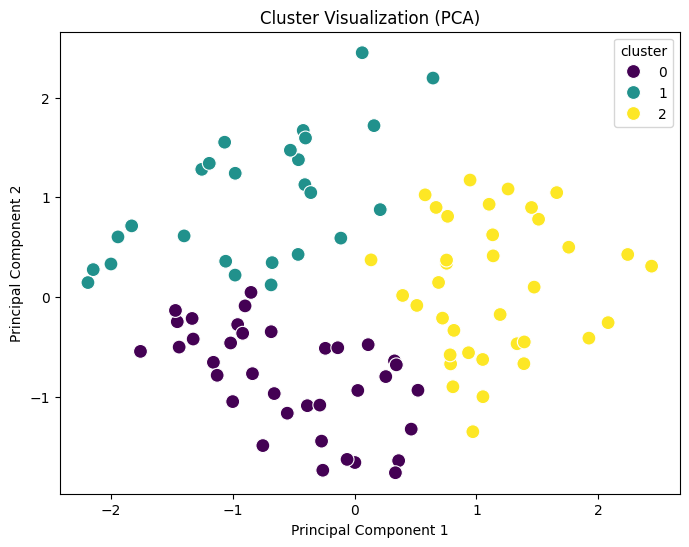

In [4]:
# Import libraries for visualization and evaluation
import seaborn as sns
from sklearn.metrics import confusion_matrix

# For evaluation, we will compare our clustering results to our watch time segmentation.
# Map the watch_segment to numeric values to allow comparison.
segment_mapping = {'low': 0, 'medium': 1, 'high': 2}
df_encoded['watch_segment_num'] = df_encoded['watch_segment'].map(segment_mapping)

# Create a confusion matrix comparing the ground truth segmentation to the clustering labels.
cm = confusion_matrix(df_encoded['watch_segment_num'], df_encoded['cluster'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Cluster')
plt.ylabel('Watch Segment (mapped: low=0, medium=1, high=2)')
plt.title('Confusion Matrix: Watch Segment vs. Clustering')
plt.show()

# Additionally, print a cross-tabulation for inspection.
print("Cross-tabulation between watch_segment and cluster:")
print(pd.crosstab(df_encoded['watch_segment'], df_encoded['cluster']))

# Optional: Visualize clusters using a PCA projection into 2 dimensions.
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_encoded['cluster'], palette='viridis', s=100)
plt.title("Cluster Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

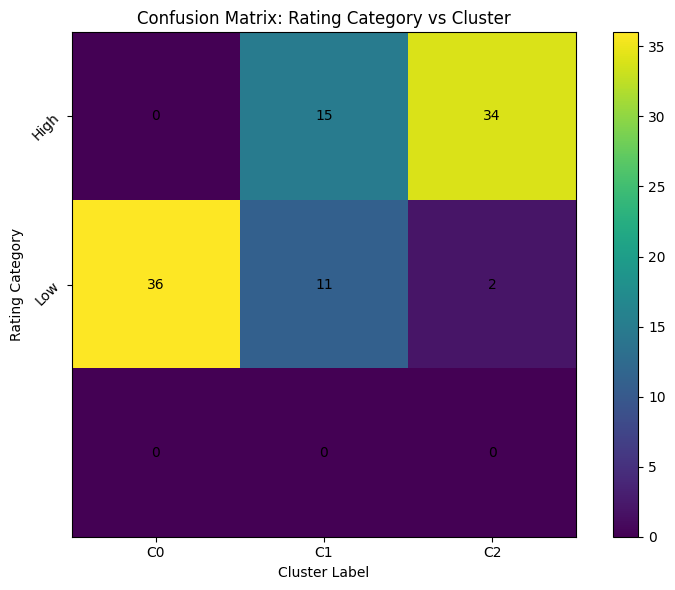

In [7]:
# Cell 6: Confusion Matrix — Rating Category vs. Cluster Assignment
# Discretize average rating into Low/High based on median
median_rating = df['avg_rating_given'].median()
df['rating_category'] = pd.cut(df['avg_rating_given'],
                               bins=[-np.inf, median_rating, np.inf],
                               labels=['Low', 'High'])
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder  # Importing the LabelEncoder class
# Encode rating category
le_rating = LabelEncoder()
df['rating_encoded'] = le_rating.fit_transform(df['rating_category'])
# Compute confusion matrix
# Use df_encoded instead of df to access the 'cluster' column
cm_rating = confusion_matrix(df['rating_encoded'], df_encoded['cluster'])  # Changed line
plt.figure(figsize=(8, 6))
plt.imshow(cm_rating, interpolation='nearest')
plt.title('Confusion Matrix: Rating Category vs Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Rating Category')
plt.colorbar()
# Tick labels
# Assuming n_clusters is defined previously, else define it as k_optimal
n_clusters = 3 # Or use: n_clusters = k_optimal if k_optimal is available in this cell
plt.xticks(np.arange(n_clusters), [f"C{i}" for i in range(n_clusters)])
plt.yticks(np.arange(len(le_rating.classes_)), le_rating.classes_, rotation=45)
# Annotate counts
for i in range(cm_rating.shape[0]):
    for j in range(cm_rating.shape[1]):
        plt.text(j, i, cm_rating[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()